# Ames, Iowa Market Analysis
##### By: Nick Lomeli

-----
---

### Imports

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.feature_selection import RFE

plt.style.use('ggplot')

-----
### Read in the sample data to see what the final product should look like

In [2]:
sample_df = pd.read_csv('./sample_sub_reg.csv')

In [3]:
sample_df.head(2)

,Id,SalePrice
0,2,181479.1217
1,4,181479.1217


------
## Read in the training and test data

In [4]:
train = pd.read_csv('./train.csv')

In [5]:
test = pd.read_csv('./test.csv')

In [6]:
train.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


In [7]:
test.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD


----
----
## Explore the data / EDA

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

/var/folders/3g/6r2vyt6x7j5_f821l31rqp640000gn/T/ipykernel_4985/276044123.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False), annot = True);


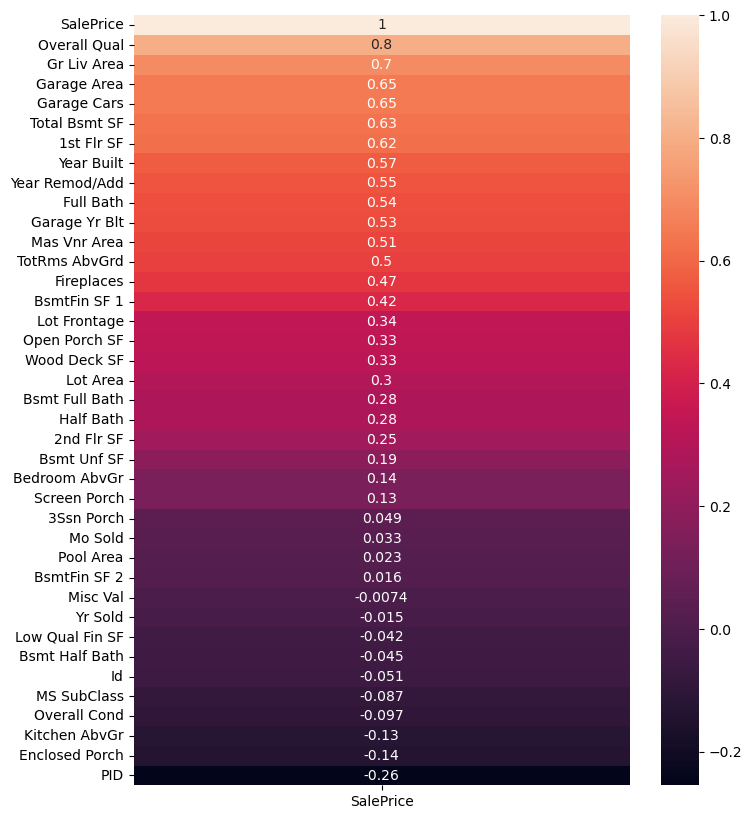

In [11]:
plt.figure(figsize = (8, 10))
sns.heatmap(train.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False), annot = True);

In [12]:
train.isna().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
               ... 
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
SalePrice         0
Length: 81, dtype: int64

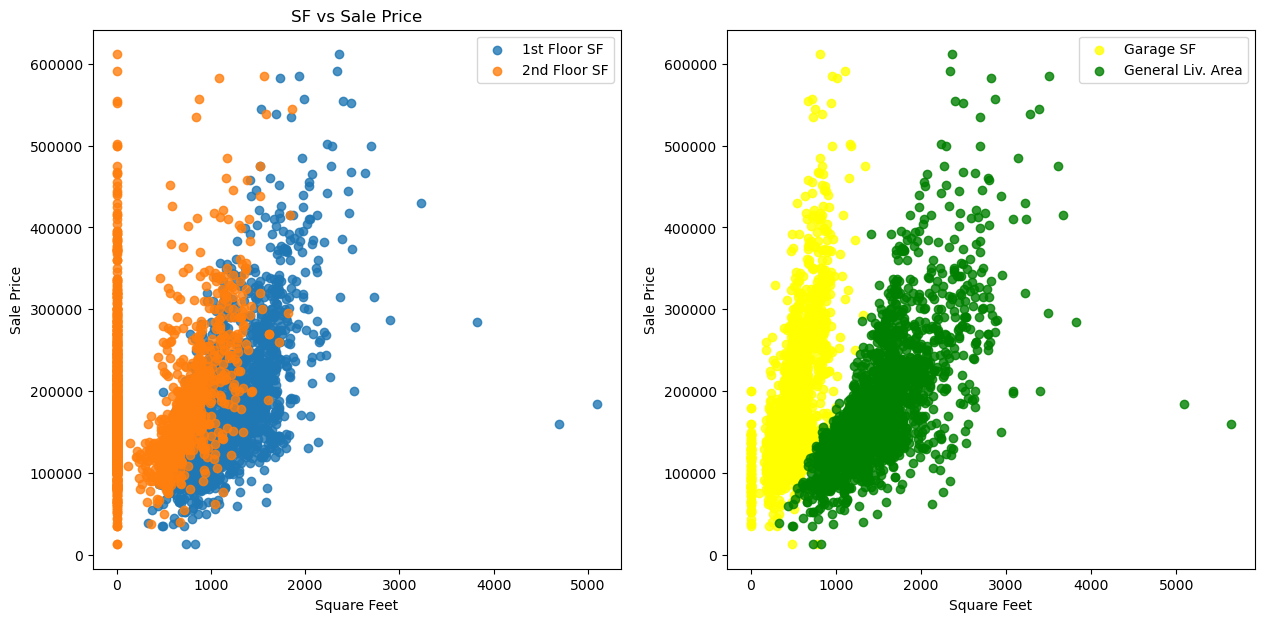

In [81]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))

ax[0].scatter(train['1st Flr SF'], train['SalePrice'], alpha = .8, label = '1st Floor SF')
ax[0].scatter(train['2nd Flr SF'], train['SalePrice'], alpha = .8, label = '2nd Floor SF')
ax[0].legend()
ax[0].set_ylabel('Sale Price')
ax[0].set_xlabel('Square Feet')
ax[0].set_title('SF vs Sale Price')

ax[1].scatter(train['Garage Area'], train['SalePrice'], alpha = .8, label = 'Garage SF', c = 'yellow')
ax[1].scatter(train['Gr Liv Area'], train['SalePrice'], alpha = .8, label = 'General Liv. Area', c = 'green')
ax[1].legend()
ax[1].set_ylabel('Sale Price')
ax[1].set_xlabel('Square Feet');

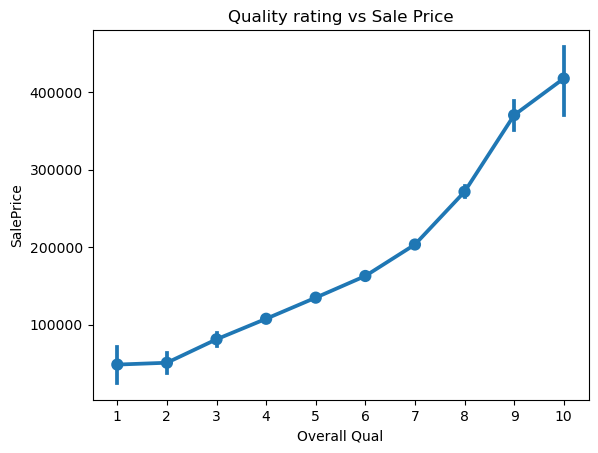

In [14]:
sns.pointplot(data = train, x = 'Overall Qual', y = 'SalePrice')
plt.title('Quality rating vs Sale Price');

------
# Modeling
- Create X and y
- Train/test split

In [15]:
X = train.drop(columns = 'SalePrice')
y = train['SalePrice']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

-----
## Model 1:

In [17]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), make_column_selector(dtype_include = object)),
    remainder = 'passthrough',
    verbose_feature_names_out = False,
    n_jobs = -1,
    sparse_threshold = 0
)

In [18]:
pipe = make_pipeline(ct,
                     KNNImputer(),
                     StandardScaler(),
                     RFE(estimator = Ridge()),
                     Ridge()
                    )

In [19]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x1770ca450>)],
                     verbose_feature_names_out=False)),
  ('knnimputer', KNNImputer()),
  ('standardscaler', StandardScaler()),
  ('rfe', RFE(estimator=Ridge())),
  ('ridge', Ridge())],
 'verbose': False,
 'columntransformer': ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  <sklearn.compose._column

In [31]:
params = {
    'knnimputer__n_neighbors': [3, 4, 5],
    'rfe__estimator__alpha': [.001, .01],
    'ridge__alpha': [100]
}

In [32]:
gs = GridSearchCV(pipe, params, n_jobs = -1)

In [33]:
train.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


In [34]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x1770ca450>)],
                                                          verbose_feature_names_out=False)),
                                       ('knnimputer', KNNImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('rfe', RFE(estimator=Ridge())),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'knnimputer__n_neighbors': [3, 4, 5],
                         'rfe__estimator__alpha': [0.001, 0.01],
                         'ridge__alpha': [100]})

In [35]:
gs.score(X_test, y_test)

0.9038894142735685

In [36]:
gs.score(X_train, y_train)

0.9454297864460751

In [37]:
mean_squared_error(y_test, gs.predict(X_test), squared = False)

25938.516928323592

----
### Create a Null model and compare RMSE

In [38]:
baseline = np.full_like(y_test, y.mean())

In [39]:
mean_squared_error(y_test, baseline, squared = False)

83694.03397640305

In [40]:
gs.best_params_

{'knnimputer__n_neighbors': 3,
 'rfe__estimator__alpha': 0.01,
 'ridge__alpha': 100}

---
### Store Model 1's predictions in a DataFrame as shown in the sample df

In [42]:
predictions_1 = pd.DataFrame()

In [43]:
predictions_1['Id'] = test['Id']

In [44]:
predictions_1['SalePrice'] = gs.predict(test)

In [45]:
predictions_1

,Id,SalePrice
0,2658,145307.537668
1,2718,157519.235222
2,2414,219595.165123
3,1989,108428.473673
4,625,176881.343101
...,...,...
873,1662,190921.936703
874,1234,212534.132991
875,1373,121876.281641
876,1672,113103.545991



### Export Predictions_1 DataFrame as a csv

In [46]:
# predictions_1.to_csv('../../Data/P2_Predictions')

----
------
----
## Model 2:

In [50]:
ct2 = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), make_column_selector(dtype_include = object)),
    remainder = 'passthrough',
    verbose_feature_names_out = False,
    n_jobs = -1,
    sparse_threshold = 0
)

In [51]:
pipe2 = make_pipeline(
    ct2,
    SimpleImputer(),
    StandardScaler(),
    RFE(estimator = Ridge()),
    Lasso(max_iter = 2_000_000)
)

In [52]:
pipe2.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x177c5e3d0>)],
                     verbose_feature_names_out=False)),
  ('simpleimputer', SimpleImputer()),
  ('standardscaler', StandardScaler()),
  ('rfe', RFE(estimator=Ridge())),
  ('lasso', Lasso(max_iter=2000000))],
 'verbose': False,
 'columntransformer': ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  <s

In [53]:
params2 = {
    'rfe__estimator__alpha': [1],
    'lasso__alpha': [20, 25]
}

In [54]:
gs2 = GridSearchCV(pipe2, params2, n_jobs = -1)

In [55]:
gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x177c5e3d0>)],
                                                          verbose_feature_names_out=False)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('rfe', RFE(estimator=Ridge())),
                                       ('lasso', Lasso(max_iter=2000000))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [20, 25],
                         'rfe__estimator__alpha': [1]})

In [56]:
gs2.score(X_test, y_test)

0.9063329265462194

In [57]:
gs2.score(X_train, y_train)

0.9474703829288118

In [58]:
mean_squared_error(y_test, gs2.predict(X_test), squared = False)

25606.66410759098

In [64]:
mean_squared_error(y_test, baseline, squared = False)

83694.03397640305

In [59]:
gs2.best_params_

{'lasso__alpha': 25, 'rfe__estimator__alpha': 1}

In [60]:
predictions_2 = pd.DataFrame()

In [61]:
predictions_2['Id'] = test['Id']

In [63]:
predictions_2['SalePrice'] = gs2.predict(test)

In [77]:
predictions_2.head(3)

,Id,SalePrice
0,2658,147974.457615
1,2718,155018.936346
2,2414,215221.662713


### Export Preditions_2 DataFrame as a csv 

In [78]:
predictions_2.to_csv('../../Data/Predictions_2')

-----
------
-----
# Model 3

In [65]:
ct3 = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), make_column_selector(dtype_include = object)),
    remainder = 'passthrough',
    verbose_feature_names_out = False,
    n_jobs = -1,
    sparse_threshold = 0
)

In [66]:
pipe3 = make_pipeline(
    ct3,
    KNNImputer(),
    StandardScaler(),
    RFE(estimator = Ridge()),
    KNeighborsRegressor(n_jobs = -1)
)

In [67]:
pipe3.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                     transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x28be6bd50>)],
                     verbose_feature_names_out=False)),
  ('knnimputer', KNNImputer()),
  ('standardscaler', StandardScaler()),
  ('rfe', RFE(estimator=Ridge())),
  ('kneighborsregressor', KNeighborsRegressor(n_jobs=-1))],
 'verbose': False,
 'columntransformer': ColumnTransformer(n_jobs=-1, remainder='passthrough', sparse_threshold=0,
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                     

In [68]:
params3 = {
    'rfe__estimator__alpha': [100, 150, 200],
    'kneighborsregressor__metric': ['l1']
}
    

In [69]:
gs3 = GridSearchCV(pipe3, params3, n_jobs = -1)

In [70]:
gs3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x28be6bd50>)],
                                                          verbose_feature_names_out=False)),
                                       ('knnimputer', KNNImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('rfe', RFE(estimator=Ridge())),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'kneighborsregressor__metric': ['l1'],
                         'rfe__estimator__alpha': [100, 150, 200]})

In [71]:
gs3.score(X_test, y_test)

0.8362247181071351

In [72]:
gs3.score(X_train, y_train)

0.8905395823770175

In [73]:
mean_squared_error(y_test, gs3.predict(X_test), squared = False)

33859.7468546348

In [74]:
mean_squared_error(y_test, baseline, squared = False)

83694.03397640305

In [327]:
gs3.best_params_

{'kneighborsregressor__metric': 'l1', 'rfe__estimator__alpha': 100}

### Create Predictions_3 DataFrame and export as csv

In [75]:
predictions_3 = pd.DataFrame()

predictions_3['Id'] = test['Id']

predictions_3['SalePrice'] = gs3.predict(test)

In [76]:
predictions_3.head(3)

,Id,SalePrice
0,2658,109500.0
1,2718,144800.0
2,2414,190822.0


In [79]:
#predictions_3.to_csv('../../Data/Predictions_3')

----
----
---

## Interpret coefficients of the best model

In [129]:
all_cols = gs2.best_estimator_.named_steps.columntransformer.get_feature_names_out()

In [130]:
rfe_cols = all_cols[gs2.best_estimator_.named_steps.rfe.support_]

In [131]:
coefs = gs2.best_estimator_.named_steps.lasso.coef_

In [132]:
len(rfe_cols), len(coefs)

(152, 152)

In [133]:
coef_df = pd.DataFrame(zip(rfe_cols, coefs), columns = ['feature', 'coef'])

In [134]:
coef_df.sort_values(by = 'coef', ascending = False).head(15)

,feature,coef
140,2nd Flr SF,14314.182255
139,1st Flr SF,11747.567189
141,Gr Liv Area,11424.099687
131,Overall Qual,9916.064651
133,Year Built,9681.389100
138,Total Bsmt SF,9089.856241
112,Garage Qual_Ex,7213.884898
136,BsmtFin SF 1,7055.553416
130,Lot Area,5994.858577
135,Mas Vnr Area,5647.209916


In [135]:
coef_df.sort_values(by = 'coef').head(15)

,feature,coef
51,Roof Matl_ClyTile,-17035.063737
119,Misc Feature_Elev,-13486.991914
114,Garage Cond_Ex,-5636.008637
151,Pool Area,-4179.771114
128,MS SubClass,-3282.277169
144,Bedroom AbvGr,-2996.111012
145,Kitchen AbvGr,-2825.701810
17,Neighborhood_Edwards,-2217.822895
11,Land Slope_Sev,-2210.680145
77,Bsmt Qual_Gd,-2101.011705


- Holding all else constant, for every 1 STD increase in 2nd Flr SF, we expect to see an increase of \$14,314.18 in the sale price
- Holding all else constant, for every 1 STD increase in 1st Flr SF, we expect to see an increase of \$11,747.56 in the sale price
- Holding all else constant, for every 1 STD increase in Roof Material Clay Tile, we expect to see a decrease of \$17,035.06 in the sale price

